In [5]:
import numpy as np
import napari
from skimage.measure import regionprops
import concurrent.futures

from src import asymmetry_3D
from src import prepare_center_pca
from src.asymmetry_3D import *
from src.utils import *
from src.prepare_center_pca_3D import *

%load_ext autoreload
%autoreload 2
V = napari.Viewer(ndisplay = 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Load data

A note on python arrays: they start indexing at 0 i.e., the first element of an array is Array[0], unlike matlab where this would be Array(1)\
Volume images are arrays with 3 axes. In python the axes order is Array[z, y, x], see the schematic below\
\
Important! At the moment, this code assumes that the images have been binarized previously. All background pixels are 0.

The computation takes a few minutes for volumes ~ 100 x 150 x 100 voxels, increase this at your own risk!\
*TO DO*\
automate BFGS bounds

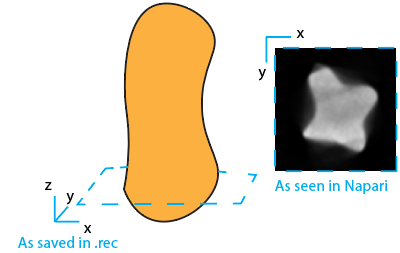

In [4]:
V.add_image(Q)

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\asyncio\base_events.py", line 607, in run_forever
    self._run_once()
  File "c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\asyncio\base_events.py", line 1922, in _run_once
    hand

<Image layer 'Q [1]' at 0x1f1c5e15cd0>

In [2]:
filename = r"D:\Data\2024_03_BipyKin2\Grid2E6_AgBipy_30m\Grid2E6_AgBipy_30m_P1_em25_alignAndFilter.rec" # Data must be binarized but not necessarily aligned
Q = read_data(filename) # Can read .tif(f), .mrc, .rec

print(f'volume size: {Q.shape}')
print(f'number of voxels: {Q.shape[0]*Q.shape[1]*Q.shape[2]}')
print(f'number of surface voxels: {np.count_nonzero(get_edges(Q))}')

c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\mrcfile\mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
c:\Users\rgirod\AppData\Local\miniconda3\envs\Register\Lib\site-packages\mrcfile\mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


volume size: (301, 123, 123)
number of voxels: 4553829
number of surface voxels: 201557


Run the cell below if the data have not been aligned to center and major axis vertical yet. This calculation requires the long axis of the image to be in position 0

In [ ]:
Q = translate_center_of_mass(Q)
Q = rotate_pca(Q)

2. Perform an initial grid search. Watch out! Computation cost scales with ${N_{parameters}}^6$ and ~ ${N_{voxels}}^1$

In [29]:
''' Parameters ''' 
n_shifts = 3 # for now, must be odd to include 0
l_shifts = 1 # in pixels
n_angles = 30 # 60 angles is quite good already, must be even for rod_like

distance = 'SE' # 'IoU', 'SE' or 'Hausdorff'
rod_like = True # if True, will limit rotations to the major and 1 minor axes, with [-10°+10°] at +/- 180° for the minor

''' Function '''
if n_shifts == 0:
    iter_u = [0]
    iter_v = [0]
    iter_w = [0]
else:
    lim = (n_shifts // 2) * l_shifts
    iter_u = np.linspace(-1 * lim, lim, n_shifts,  dtype = 'int') # number of X points in the grid search, centered
    iter_v = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Y points in the grid search, centered
    iter_w = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Z points in the grid search, centered

if rod_like:
    iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Z axis
    n_angles_minor_ud = n_angles // 2
    if not n_angles_minor_ud % 2:
        n_angles_minor_ud -= 1
    iter_b = np.concatenate([ 
        np.linspace(-10, 10, n_angles_minor_ud, endpoint = True, dtype = 'int'),
        np.linspace(170, 190, n_angles_minor_ud, endpoint = True, dtype = 'int')
    ]) # rotations about Y axis
    iter_c = [0] # rotations about X axis

else:
    iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Z axis
    iter_b = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Y axis
    iter_c = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about X axis


# Need to decouple col, row and angle idx to have a finer search with angles
# Also could have a "rod" or "sphere" case where less rotation are required

print(f'Grid search in u: {iter_u}')
print(f'Grid search in v: {iter_v}')
print(f'Grid search in w: {iter_w}')

print(f'Grid search in a: {iter_a}')
print(f'Grid search in b: {iter_b}')
print(f'Grid search in c: {iter_c}')

iter_param = [(u, v, w, a, b, c) 
              for u in iter_u
              for v in iter_v
              for w in iter_w 
              for a in iter_a
              for b in iter_b
              for c in iter_c]

Q_mirror = np.flip(Q, axis = 1)

print(f'The global minimum will be searched with {distance} over {len(iter_param)} combinations')
print(f'Estimated computation time: {eval_time_grid_search(Q, distance, iter_param)} s')

Grid search in u: [-1  0  1]
Grid search in v: [-1  0  1]
Grid search in w: [-1  0  1]
Grid search in a: [  0  12  24  36  48  60  72  84  96 108 120 132 144 156 168 180 192 204
 216 228 240 252 264 276 288 300 312 324 336 348]
Grid search in b: [-10  -9  -8  -6  -5  -3  -2   0   1   2   4   5   7   8  10 170 171 172
 174 175 177 178 180 181 182 184 185 187 188 190]
Grid search in c: [0]
The global minimum will be searched with SE over 24300 combinations
Estimated computation time: 46 s


In [30]:
''' Function '''
print(f'Searching the global minimum over {len(iter_param)} combinations ...')

# Multithreaded
to_CPU = [(Q, param, distance) for param in enumerate(iter_param)] # here param is [idx, (u, v, w, a, b, c)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(to_multiprocessing_3D, var) for var in to_CPU]
    H_global = [future.result() for future in concurrent.futures.as_completed(futures)]

# Retrieve results H_global [idx | distance]
H_global = np.array(H_global)
min_param_idx = H_global[np.argmin(H_global[:,1]), 0] # Get the lowest distance
min_param = iter_param[int(min_param_idx)]

# Rearrange H_global for [idx | u | v | alpha | distance]
H_global = H_global[np.argsort(H_global[:,0])] # Sort by idx
for i in range(len(iter_param[0])):
    H_global = np.insert(H_global, i+1, np.asarray(iter_param)[:,i], axis = 1) # Insert param

# Print results
print(f'global minimum found for parameters: {min_param} at D={H_global[:,-1].min()}')

show_param = 5 # Number of param to print
five_min = np.argsort(H_global[:,-1])[:show_param] 
print(f'{show_param} lowest parameters:\n {np.array(iter_param)[five_min]}')

Searching the global minimum over 24300 combinations ...
global minimum found for parameters: (-1, 0, 0, 0, 5, 0) at D=0.2671693836631506
5 lowest parameters:
 [[-1  0  0  0  5  0]
 [-1  0  0  0  7  0]
 [-1  0  0  0  4  0]
 [-1  0  0  0  8  0]
 [-1  0  0  0  2  0]]


3. Starting from the best results of the grid search, perform a local search using the BFGS method

In [48]:
'''
Test to find the best step size depending on the metric used
Best step size gives a change of ~1e-3 for SE, ~1.5-2e-2 for IoU
It is best to have change_translate ~ change_rotation for convergence
Note: cannot have step size < 1 px
'''
step_rot = 3 # At the moment, need to be kept > 1
step_translation = 3 # At the moment, need to be kept > 1 and integers only

test_step_size(Q, 'SE', min_param, step_rot, step_translation)

Average change for a translation step of 3 px: 3.008166e-02
Average change for a rotation step of 3°: 3.757301e-03


In [49]:
''' Parameters ''' 
distance = 'SE' # 'SE', 'IoU' or 'Hausdorff'

''' Function '''
results = minimize_distance_local_3D(Q, distance, min_param, step_rot, step_translation)
best_param = descale_parameters(*results.x, step_rot, step_translation)

if distance == 'Hausdorff':
    d_max = regionprops(Q)[0].feret_diameter_max
    print(f'Hausdorff distance: {results.fun / d_max}')

minimizing the chirality distance from initialization: (-1, 0, 0, 0, 5, 0)
minimization completed after 1 iterations
Best parameters: [-1.0, -0.0, -0.0, -0.05, 4.94, -0.05] at 0.27
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.2670734896696016
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
             1.000e+00]
      nit: 1
      jac: [ 2.594e+03  3.702e+03  2.744e+03  1.892e+02  1.953e+02
             7.148e+02]
     nfev: 77
     njev: 11
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


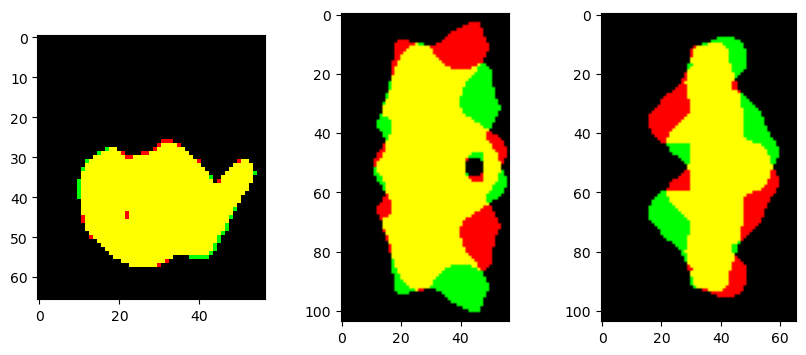

In [50]:
''' Display results in 2D'''
show_result_BFGS(Q, best_param)

In [10]:
V = napari.Viewer(ndisplay = 3)

In [51]:
''' Display results in 3D'''
show_result_BFGS(Q, min_param, V)